In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import urllib3

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 데이터 불러오기

In [3]:
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

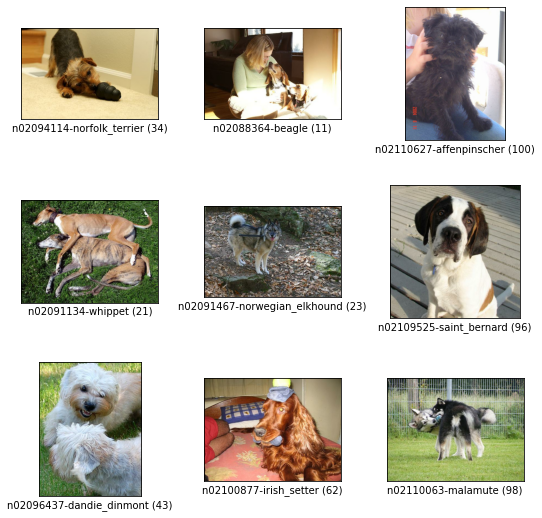

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

# Augmentation 적용하기

- Tensorflow API 사용

    random_brightness()
    
    random_contrast()
    
    random_crop()
    
    random_flip_left_right()
    
    random_flip_up_down()
    
    random_hue()
    
    random_jpeg_quality()
    
    random_saturation()


In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- Random Augmentation

In [8]:
# make random augment function
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop합니다.
    image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
    return image, label

# 비교실험

In [9]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

In [12]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 3

tf.random.set_seed(2020)
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 118s 157ms/step - loss: 2.2135 - accuracy: 0.4498 - val_loss: 3.1629 - val_accuracy: 0.2543
Epoch 2/20
750/750 [==============================] - 116s 155ms/step - loss: 0.7672 - accuracy: 0.7878 - val_loss: 1.0920 - val_accuracy: 0.6774
Epoch 3/20
750/750 [==============================] - 116s 155ms/step - loss: 0.2801 - accuracy: 0.9369 - val_loss: 0.9581 - val_accuracy: 0.7228
Epoch 4/20
750/750 [==============================] - 117s 156ms/step - loss: 0.1132 - accuracy: 0.9842 - val_loss: 0.9269 - val_accuracy: 0.7345
Epoch 5/20
750/750 [==============================] - 116s 155ms/step - loss: 0.0366 - accuracy: 0.9972 - val_loss: 0.9206 - val_accuracy: 0.7404
Epoch 6/20
750/750 [==============================] - 117s 156ms/step - loss: 0.0157 - accuracy: 0.9998 - val_loss: 0.9147 - val_accuracy: 0.7478
Epoch 7/20
750/750 [==============================] - 118s 157ms/step - loss: 0.0208 - accuracy: 0.9993 - val_loss: 0.9456 -

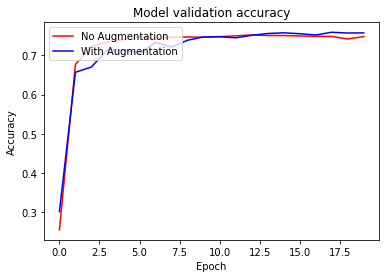

In [13]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

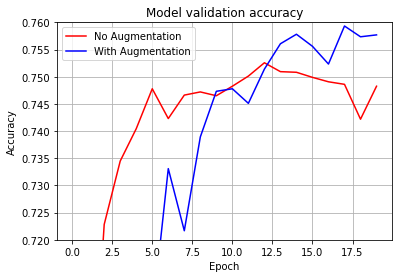

In [14]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

# Cutmix Augmentation

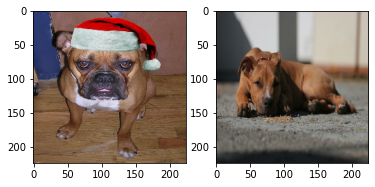

In [12]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [13]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(77, shape=(), dtype=int32) tf.Tensor(139, shape=(), dtype=int32) tf.Tensor(221, shape=(), dtype=int32) tf.Tensor(223, shape=(), dtype=int32)


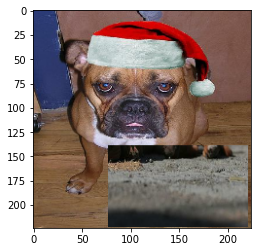

In [14]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [15]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.24107143,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [16]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

# Mixup Augmentation

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.2582171 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.7417829 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

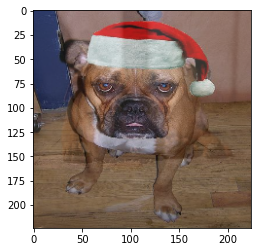

In [17]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [18]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

# Project

## 1. Augmentation을 적용한 데이터 셋 만들기

In [19]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            lambda image, label: (image, tf.one_hot(label, num_classes)),
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 2. 모델 만들기

In [20]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [21]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [22]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [23]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [24]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [25]:
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])


In [26]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)

ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 3. 모델 훈련하기

In [27]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 3

tf.random.set_seed(2020)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [28]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 113s 151ms/step - loss: 2.1979 - accuracy: 0.4516 - val_loss: 3.2967 - val_accuracy: 0.2114
Epoch 2/20
750/750 [==============================] - 113s 151ms/step - loss: 0.7858 - accuracy: 0.7780 - val_loss: 1.1520 - val_accuracy: 0.6638
Epoch 3/20
750/750 [==============================] - 113s 150ms/step - loss: 0.3022 - accuracy: 0.9278 - val_loss: 1.0003 - val_accuracy: 0.7143
Epoch 4/20
750/750 [==============================] - 112s 149ms/step - loss: 0.1005 - accuracy: 0.9859 - val_loss: 0.9252 - val_accuracy: 0.7336
Epoch 5/20
750/750 [==============================] - 112s 150ms/step - loss: 0.0304 - accuracy: 0.9983 - val_loss: 0.9159 - val_accuracy: 0.7424
Epoch 6/20
750/750 [==============================] - 113s 151ms/step - loss: 0.0303 - accuracy: 0.9977 - val_loss: 0.9371 - val_accuracy: 0.7395
Epoch 7/20
750/750 [==============================] - 113s 151ms/step - loss: 0.0251 - accuracy: 0.9977 - val_loss: 0.9503 -

In [29]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 113s 151ms/step - loss: 2.2386 - accuracy: 0.4353 - val_loss: 2.8812 - val_accuracy: 0.2774
Epoch 2/20
750/750 [==============================] - 114s 152ms/step - loss: 0.9441 - accuracy: 0.7279 - val_loss: 1.3009 - val_accuracy: 0.6306
Epoch 3/20
750/750 [==============================] - 114s 152ms/step - loss: 0.5379 - accuracy: 0.8468 - val_loss: 1.2309 - val_accuracy: 0.6606
Epoch 4/20
750/750 [==============================] - 113s 150ms/step - loss: 0.2685 - accuracy: 0.9354 - val_loss: 1.0445 - val_accuracy: 0.7048
Epoch 5/20
750/750 [==============================] - 113s 151ms/step - loss: 0.1731 - accuracy: 0.9632 - val_loss: 1.0635 - val_accuracy: 0.7070
Epoch 6/20
750/750 [==============================] - 114s 152ms/step - loss: 0.0954 - accuracy: 0.9830 - val_loss: 1.0228 - val_accuracy: 0.7198
Epoch 7/20
750/750 [==============================] - 114s 153ms/step - loss: 0.0748 - accuracy: 0.9877 - val_loss: 1.0640 -

In [30]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 116s 154ms/step - loss: 3.8573 - accuracy: 0.2055 - val_loss: 3.5540 - val_accuracy: 0.1845
Epoch 2/20
750/750 [==============================] - 117s 156ms/step - loss: 2.9726 - accuracy: 0.4271 - val_loss: 1.3674 - val_accuracy: 0.6278
Epoch 3/20
750/750 [==============================] - 118s 157ms/step - loss: 2.6677 - accuracy: 0.5255 - val_loss: 1.4327 - val_accuracy: 0.6124
Epoch 4/20
750/750 [==============================] - 118s 158ms/step - loss: 2.4635 - accuracy: 0.5846 - val_loss: 1.2670 - val_accuracy: 0.6519
Epoch 5/20
750/750 [==============================] - 119s 159ms/step - loss: 2.3345 - accuracy: 0.6303 - val_loss: 1.1142 - val_accuracy: 0.6941
Epoch 6/20
750/750 [==============================] - 120s 160ms/step - loss: 2.2035 - accuracy: 0.6662 - val_loss: 1.2144 - val_accuracy: 0.6677
Epoch 7/20
750/750 [==============================] - 121s 161ms/step - loss: 2.0814 - accuracy: 0.7033 - val_loss: 1.2283 -

In [31]:
history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # augmentation & cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 115s 153ms/step - loss: 3.8609 - accuracy: 0.2016 - val_loss: 3.2351 - val_accuracy: 0.2233
Epoch 2/20
750/750 [==============================] - 113s 151ms/step - loss: 3.0386 - accuracy: 0.4053 - val_loss: 1.3903 - val_accuracy: 0.6140
Epoch 3/20
750/750 [==============================] - 113s 151ms/step - loss: 2.7292 - accuracy: 0.4988 - val_loss: 1.3059 - val_accuracy: 0.6442
Epoch 4/20
750/750 [==============================] - 113s 151ms/step - loss: 2.5591 - accuracy: 0.5499 - val_loss: 1.2039 - val_accuracy: 0.6576
Epoch 5/20
750/750 [==============================] - 113s 151ms/step - loss: 2.4091 - accuracy: 0.6012 - val_loss: 1.2582 - val_accuracy: 0.6578
Epoch 6/20
750/750 [==============================] - 113s 151ms/step - loss: 2.3310 - accuracy: 0.6161 - val_loss: 1.1639 - val_accuracy: 0.6810
Epoch 7/20
750/750 [==============================] - 113s 151ms/step - loss: 2.2200 - accuracy: 0.6558 - val_loss: 1.2215 -

In [32]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 110s 146ms/step - loss: 2.2001 - accuracy: 0.4543 - val_loss: 3.1972 - val_accuracy: 0.2298
Epoch 2/20
750/750 [==============================] - 111s 148ms/step - loss: 0.6951 - accuracy: 0.8138 - val_loss: 1.0823 - val_accuracy: 0.6817
Epoch 3/20
750/750 [==============================] - 112s 149ms/step - loss: 0.2989 - accuracy: 0.9321 - val_loss: 1.1047 - val_accuracy: 0.6824
Epoch 4/20
750/750 [==============================] - 111s 148ms/step - loss: 0.1159 - accuracy: 0.9833 - val_loss: 0.9751 - val_accuracy: 0.7188
Epoch 5/20
750/750 [==============================] - 112s 149ms/step - loss: 0.0536 - accuracy: 0.9953 - val_loss: 0.9625 - val_accuracy: 0.7238
Epoch 6/20
750/750 [==============================] - 112s 150ms/step - loss: 0.0315 - accuracy: 0.9975 - val_loss: 0.9945 - val_accuracy: 0.7224
Epoch 7/20
750/750 [==============================] - 113s 151ms/step - loss: 0.0175 - accuracy: 0.9990 - val_loss: 0.9506 -

In [33]:
history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug_mixup, # augmentation & mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 111s 148ms/step - loss: 2.2278 - accuracy: 0.4468 - val_loss: 2.9743 - val_accuracy: 0.2706
Epoch 2/20
750/750 [==============================] - 110s 147ms/step - loss: 0.9726 - accuracy: 0.7197 - val_loss: 1.4638 - val_accuracy: 0.5915
Epoch 3/20
750/750 [==============================] - 110s 147ms/step - loss: 0.5381 - accuracy: 0.8525 - val_loss: 1.0922 - val_accuracy: 0.6834
Epoch 4/20
750/750 [==============================] - 110s 147ms/step - loss: 0.2740 - accuracy: 0.9334 - val_loss: 1.0494 - val_accuracy: 0.7046
Epoch 5/20
750/750 [==============================] - 110s 147ms/step - loss: 0.1884 - accuracy: 0.9568 - val_loss: 1.2552 - val_accuracy: 0.6550
Epoch 6/20
750/750 [==============================] - 110s 147ms/step - loss: 0.1002 - accuracy: 0.9827 - val_loss: 1.0112 - val_accuracy: 0.7248
Epoch 7/20
750/750 [==============================] - 111s 148ms/step - loss: 0.0646 - accuracy: 0.9900 - val_loss: 1.0252 -

## 4. 훈련 과정 시각화

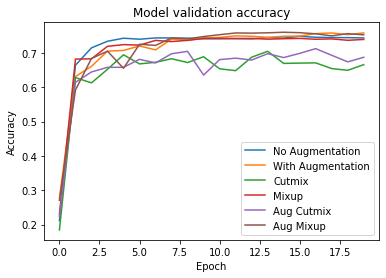

In [36]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'])
plt.plot(history_resnet50_aug.history['val_accuracy'])
plt.plot(history_resnet50_cutmix.history['val_accuracy'])
plt.plot(history_resnet50_mixup.history['val_accuracy'])
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'])
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'])

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Cutmix', 'Mixup', 'Aug Cutmix', 'Aug Mixup'])
plt.show()

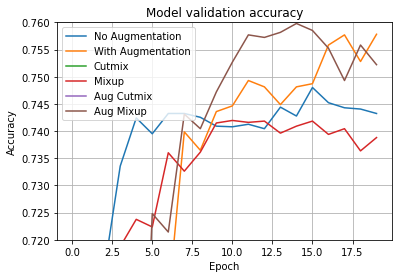

In [35]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'])
plt.plot(history_resnet50_aug.history['val_accuracy'])
plt.plot(history_resnet50_cutmix.history['val_accuracy'])
plt.plot(history_resnet50_mixup.history['val_accuracy'])
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'])
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'])

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Cutmix', 'Mixup', 'Aug Cutmix', 'Aug Mixup'], loc='upper left')
plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

augmentation만 적용하거나 augmetation & mixup을 적용한 데이터셋의 경우 학습에 더 도움이 되는 것 같다. (normal한 데이터셋과 비교해봤을 때)